In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the Public Debt (Target) and Export datasets
df_debt = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Public_Debt_2010.csv')
df_export = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Export_2010.csv')

In [5]:
df_export.head()

,Country,Ccode,2010
0,Australia,AUS,0.064196
1,Austria,AUT,0.107165
2,Belgium,BEL,0.097552
3,Canada,CAN,0.203448
4,Switzerland,CHE,0.207928


In [6]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# List of European OECD countries (Geographic)
european_oecd_countries = [
    "Austria", "Belgium", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany",
    "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
    "Netherlands", "Norway", "Poland", "Portugal", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "United Kingdom"
]

# List of non-European OECD countries
non_european_oecd_countries = [
    "Australia", "Canada", "Chile", "Colombia", "Israel", "Japan", "Korea", "Mexico", "New Zealand", "Turkey", "United States"
]

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_export, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_export = df_export.melt(id_vars=["Country"], var_name="Year", value_name="Exports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_export, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Exports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Exports'] = pd.to_numeric(df_long['Exports'], errors='coerce')

# Filter to 2010 only
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Exports"]).copy()

# IQR function with country tracking (only for Exports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].tolist()  # Track removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]  # Filter out outliers
    return df_cleaned, removed_countries

# Drop outliers only for Exports and track removed countries
df_2010_clean, removed_countries_exports = drop_outliers_iqr(df_2010, "Exports")

# Combine the list of removed countries
removed_countries = removed_countries_exports

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-exports ratio
df_2010_european['Debt_to_Exports'] = df_2010_european["Public_Debt"] / df_2010_european["Exports"]
median_ratio = df_2010_european['Debt_to_Exports'].median()
positive_european = df_2010_european[df_2010_european['Debt_to_Exports'] >= median_ratio]['Country'].tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Exports'] < median_ratio]['Country'].tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Exports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Exports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Exports): {model_pos.params['Exports']:.3f}, p-value: {model_pos.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Exports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Exports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Exports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Exports): {model_neg.params['Exports']:.3f}, p-value: {model_neg.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Exports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Exports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Exports"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Exports): {model_non_eu.params['Exports']:.3f}, p-value: {model_non_eu.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Print the countries that were removed, separated by European and non-European
if removed_european_countries:
    print("European OECD countries removed due to outliers in Exports:", removed_european_countries)
else:
    print("No European OECD countries were removed.")

if removed_non_european_countries:
    print("Non-European OECD countries removed due to outliers in Exports:", removed_non_european_countries)
else:
    print("No non-European OECD countries were removed.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Exports)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Exports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Exports (2010) after removing outliers in Exports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Exports"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Exports): {model_overall.params['Exports']:.3f}, p-value: {model_overall.pvalues['Exports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries in each European group
print("\nPositive European OECD countries (High Debt-to-Exports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Exports):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Exports) after removing outliers: 0.264, p-value: 0.384 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Exports): 0.628, p-value: 0.384
R-squared: 0.070
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.8237
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.384
Time:                        19:22:56   Log-Likelihood:                 9.5759
No. Observations:                  13   AIC:                            -15.15
Df Residuals:                      11   BIC:                            -14.02
Df Model:                           1                                         
Covariance Type:            nonrob

<ipython-input-6-f77001770933>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Exports'] = df_2010_european["Public_Debt"] / df_2010_european["Exports"]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtos

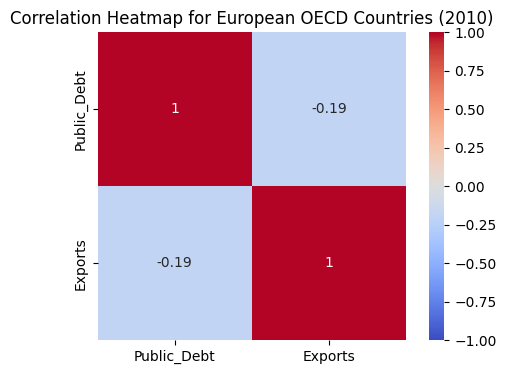

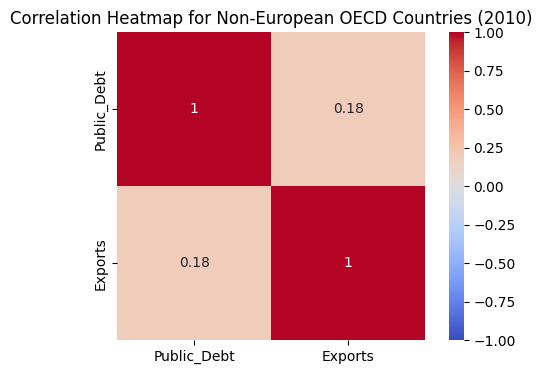

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Heatmap for European OECD countries
if len(df_2010_european) > 2:
    # Create a correlation matrix for European countries (only Public_Debt and Exports)
    corr_matrix_european = df_2010_european[["Public_Debt", "Exports"]].corr()

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix_european, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True)
    plt.title("Correlation Heatmap for European OECD Countries (2010)")
    plt.show()
else:
    print("Not enough data left for European OECD countries to create a heatmap.")

# 2. Heatmap for Non-European OECD countries
if len(df_2010_non_european) > 2:
    # Create a correlation matrix for non-European countries (only Public_Debt and Exports)
    corr_matrix_non_european = df_2010_non_european[["Public_Debt", "Exports"]].corr()

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix_non_european, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True)
    plt.title("Correlation Heatmap for Non-European OECD Countries (2010)")
    plt.show()
else:
    print("Not enough data left for non-European OECD countries to create a heatmap.")

In [8]:
#Import the cleaned GDP YOY dataset
df_GDP = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_National_GDP_2010.csv')

In [9]:
df_GDP.head()

,Country,CCode,2010
0,Australia,AUS,0.237890
1,Austria,AUT,-0.022556
2,Belgium,BEL,-0.006186
3,Canada,CAN,0.182482
4,Switzerland,CHE,0.081227


In [10]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_GDP, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_GDP = df_GDP.melt(id_vars=["Country"], var_name="Year", value_name="GDP")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_GDP, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'GDP' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "GDP"]).copy()

# IQR function with country tracking (only for GDP)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for GDP and track removed countries
df_2010_clean, removed_countries_GDP = drop_outliers_iqr(df_2010, "GDP")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_GDP if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_GDP if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-GDP ratio (for 2010)
df_2010_european['Debt_to_GDP'] = df_2010_european["Public_Debt"] / df_2010_european["GDP"]
median_ratio = df_2010_european['Debt_to_GDP'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_GDP'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_GDP'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["GDP"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["GDP"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (GDP): {model_pos.params['GDP']:.3f}, p-value: {model_pos.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["GDP"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-GDP) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["GDP"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (GDP): {model_neg.params['GDP']:.3f}, p-value: {model_neg.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["GDP"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in GDP: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["GDP"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (GDP): {model_non_eu.params['GDP']:.3f}, p-value: {model_non_eu.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in GDP)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["GDP"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and GDP (2010) after removing outliers in GDP: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["GDP"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (GDP): {model_overall.params['GDP']:.3f}, p-value: {model_overall.pvalues['GDP']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in GDP:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in GDP:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-GDP):", positive_european)
print("Negative European OECD countries (Low Debt-to-GDP):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-GDP) after removing outliers: -0.097, p-value: 0.752 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (GDP): -0.276, p-value: 0.752
R-squared: 0.009
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.081
Method:                 Least Squares   F-statistic:                    0.1046
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.752
Time:                        19:23:06   Log-Likelihood:                 6.7708
No. Observations:                  13   AIC:                            -9.542
Df Residuals:                      11   BIC:                            -8.412
Df Model:                           1                                         
Covariance Type:            nonrobust   

<ipython-input-10-bc43290abb42>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_GDP'] = df_2010_european["Public_Debt"] / df_2010_european["GDP"]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest`

<ipython-input-12-6b51f04d42ee>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-12-6b51f04d42ee>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-12-6b51f04d42ee>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-12-6b51f04d42ee>

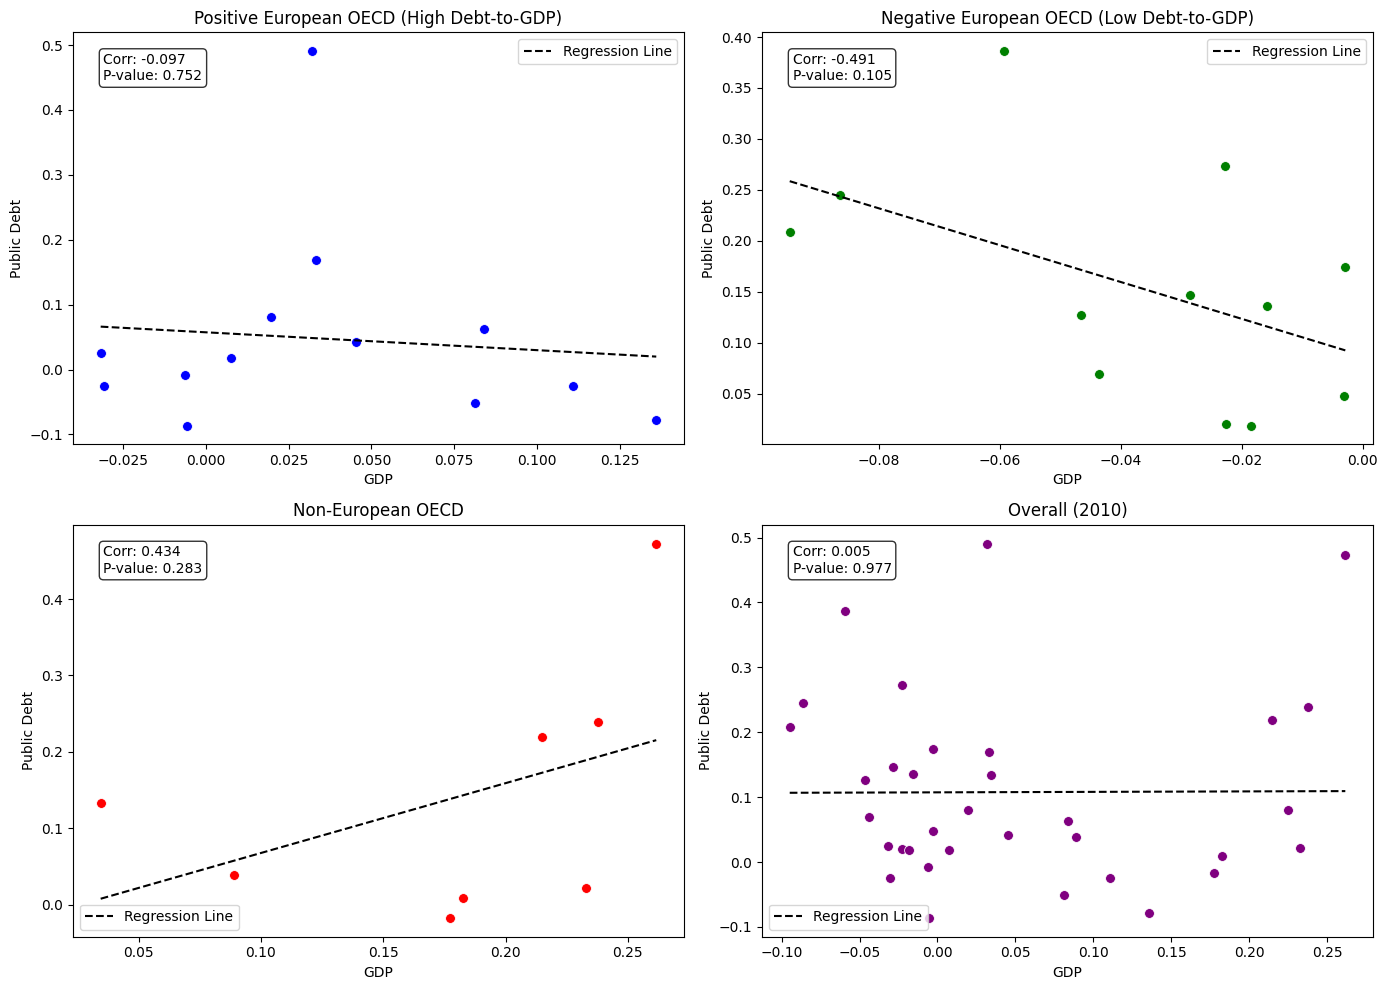

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('GDP')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('GDP')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'GDP', 'Public_Debt',
                'Positive European OECD (High Debt-to-GDP)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'GDP', 'Public_Debt',
                'Negative European OECD (Low Debt-to-GDP)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'GDP', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'GDP', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
df_import = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Import_2010.csv')
df_import.head()

,Country,Ccode,2010
0,Australia,AUS,0.127865
1,Austria,AUT,0.114177
2,Belgium,BEL,0.109172
3,Canada,CAN,0.219087
4,Switzerland,CHE,0.152574


In [14]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_import, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_import = df_import.melt(id_vars=["Country"], var_name="Year", value_name="Imports")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_import, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Imports' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Imports'] = pd.to_numeric(df_long['Imports'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Imports"]).copy()

# IQR function with country tracking (only for Imports)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Imports and track removed countries
df_2010_clean, removed_countries_imports = drop_outliers_iqr(df_2010, "Imports")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_imports if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_imports if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-imports ratio (for 2010)
df_2010_european['Debt_to_Imports'] = df_2010_european["Public_Debt"] / df_2010_european["Imports"]
median_ratio = df_2010_european['Debt_to_Imports'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Imports'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Imports'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Imports"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Imports"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Imports): {model_pos.params['Imports']:.3f}, p-value: {model_pos.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Imports"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Imports) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Imports"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Imports): {model_neg.params['Imports']:.3f}, p-value: {model_neg.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Imports"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Imports: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Imports"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Imports): {model_non_eu.params['Imports']:.3f}, p-value: {model_non_eu.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Imports)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Imports"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Imports (2010) after removing outliers in Imports: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Imports"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Imports): {model_overall.params['Imports']:.3f}, p-value: {model_overall.pvalues['Imports']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Imports:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Imports:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Imports):", positive_european)
print("Negative European OECD countries (Low Debt-to-Imports):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Imports) after removing outliers: 0.384, p-value: 0.195 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Imports): 0.782, p-value: 0.195
R-squared: 0.147
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.903
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.195
Time:                        19:26:08   Log-Likelihood:                 9.4057
No. Observations:                  13   AIC:                            -14.81
Df Residuals:                      11   BIC:                            -13.68
Df Model:                           1                                         
Covariance Type:            nonrob

<ipython-input-14-b44b820eeda1>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Imports'] = df_2010_european["Public_Debt"] / df_2010_european["Imports"]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurto

<ipython-input-17-f37ef2cee590>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-17-f37ef2cee590>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-17-f37ef2cee590>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-17-f37ef2cee590>

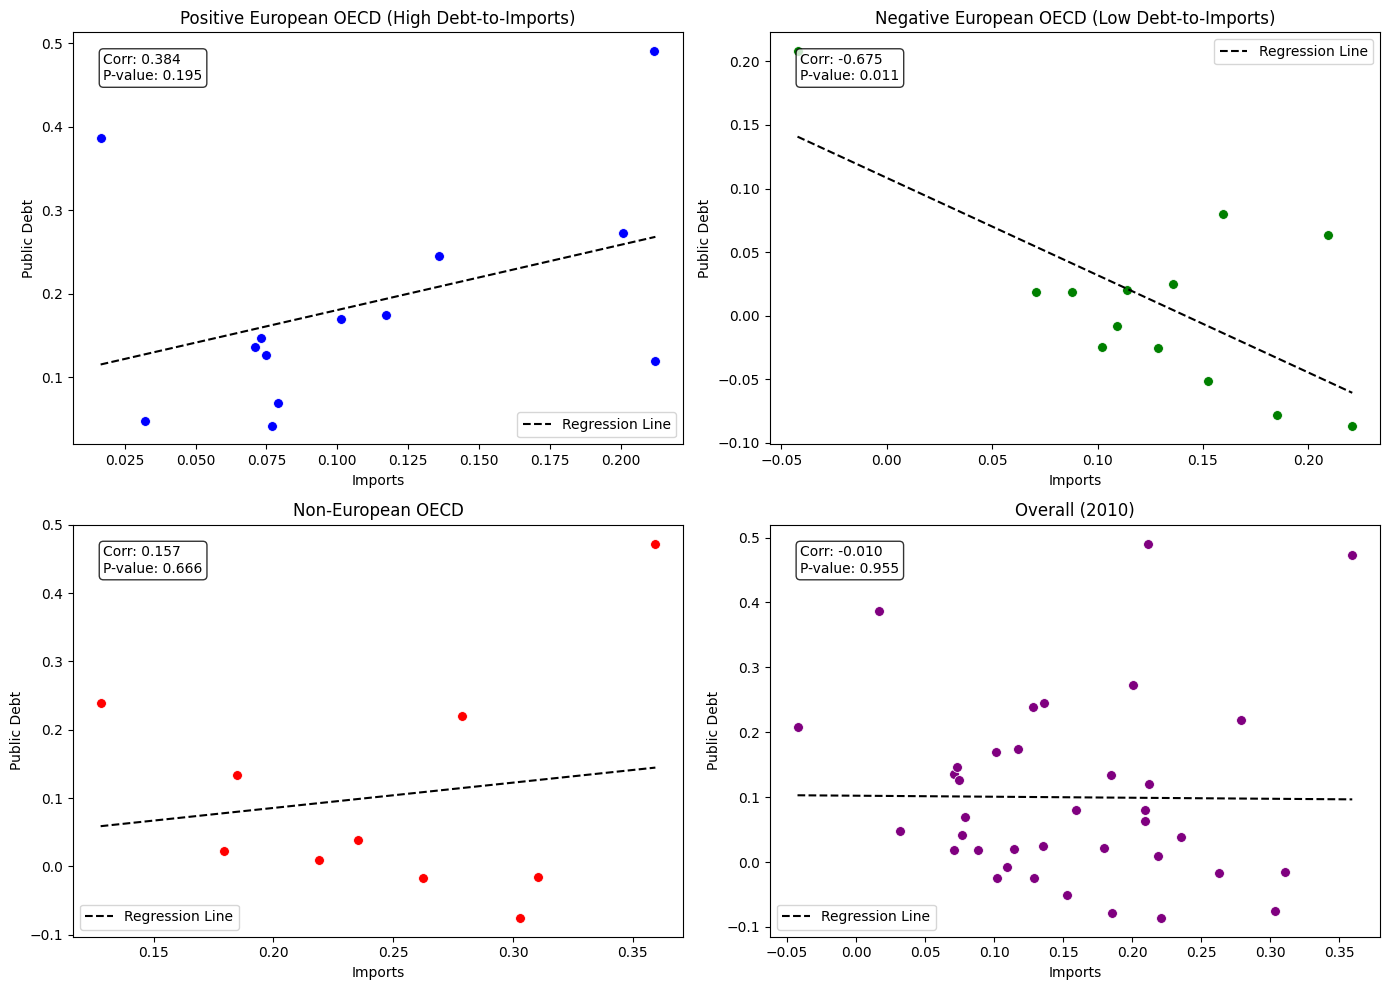

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Imports')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Imports')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Imports', 'Public_Debt',
                'Positive European OECD (High Debt-to-Imports)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Imports', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Imports)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Imports', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Imports', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
df_pop = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Pop_Growth_2010.csv')
df_pop.head()

,Country,CCode,2010
0,Australia,AUS,0.015557
1,Austria,AUT,0.002404
2,Belgium,BEL,0.009136
3,Canada,CAN,0.011114
4,Switzerland,CHE,0.010416


In [19]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_pop, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_pop = df_pop.melt(id_vars=["Country"], var_name="Year", value_name="Population")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_pop, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Population' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Population'] = pd.to_numeric(df_long['Population'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Population"]).copy()

# IQR function with country tracking (only for Population)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Population and track removed countries
df_2010_clean, removed_countries_pop = drop_outliers_iqr(df_2010, "Population")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_pop if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_pop if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-population ratio (for 2010)
df_2010_european['Debt_to_Population'] = df_2010_european["Public_Debt"] / df_2010_european["Population"]
median_ratio = df_2010_european['Debt_to_Population'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Population'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Population'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Population"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Population"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Population): {model_pos.params['Population']:.3f}, p-value: {model_pos.pvalues['Population']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Population"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Population) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Population"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Population): {model_neg.params['Population']:.3f}, p-value: {model_neg.pvalues['Population']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Population"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Population: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Population"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Population): {model_non_eu.params['Population']:.3f}, p-value: {model_non_eu.pvalues['Population']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Population)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Population"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Population (2010) after removing outliers in Population: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Population"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Population): {model_overall.params['Population']:.3f}, p-value: {model_overall.pvalues['Population']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Population:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Population:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Population):", positive_european)
print("Negative European OECD countries (Low Debt-to-Population):", negative_european)

<ipython-input-19-84f3785e7c26>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Population'] = df_2010_european["Public_Debt"] / df_2010_european["Population"]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: 

2010 Correlation for Positive European OECD countries (High Debt-to-Population) after removing outliers: 0.784, p-value: 0.003 (Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Population): 23.268, p-value: 0.003
R-squared: 0.615
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     15.97
Date:                Sun, 13 Apr 2025   Prob (F-statistic):            0.00253
Time:                        19:28:19   Log-Likelihood:                 11.820
No. Observations:                  12   AIC:                            -19.64
Df Residuals:                      10   BIC:                            -18.67
Df Model:                           1                                         
Covariance Type:            non

<ipython-input-21-db3ab32bfbb2>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-21-db3ab32bfbb2>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-21-db3ab32bfbb2>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-21-db3ab32bfbb2>

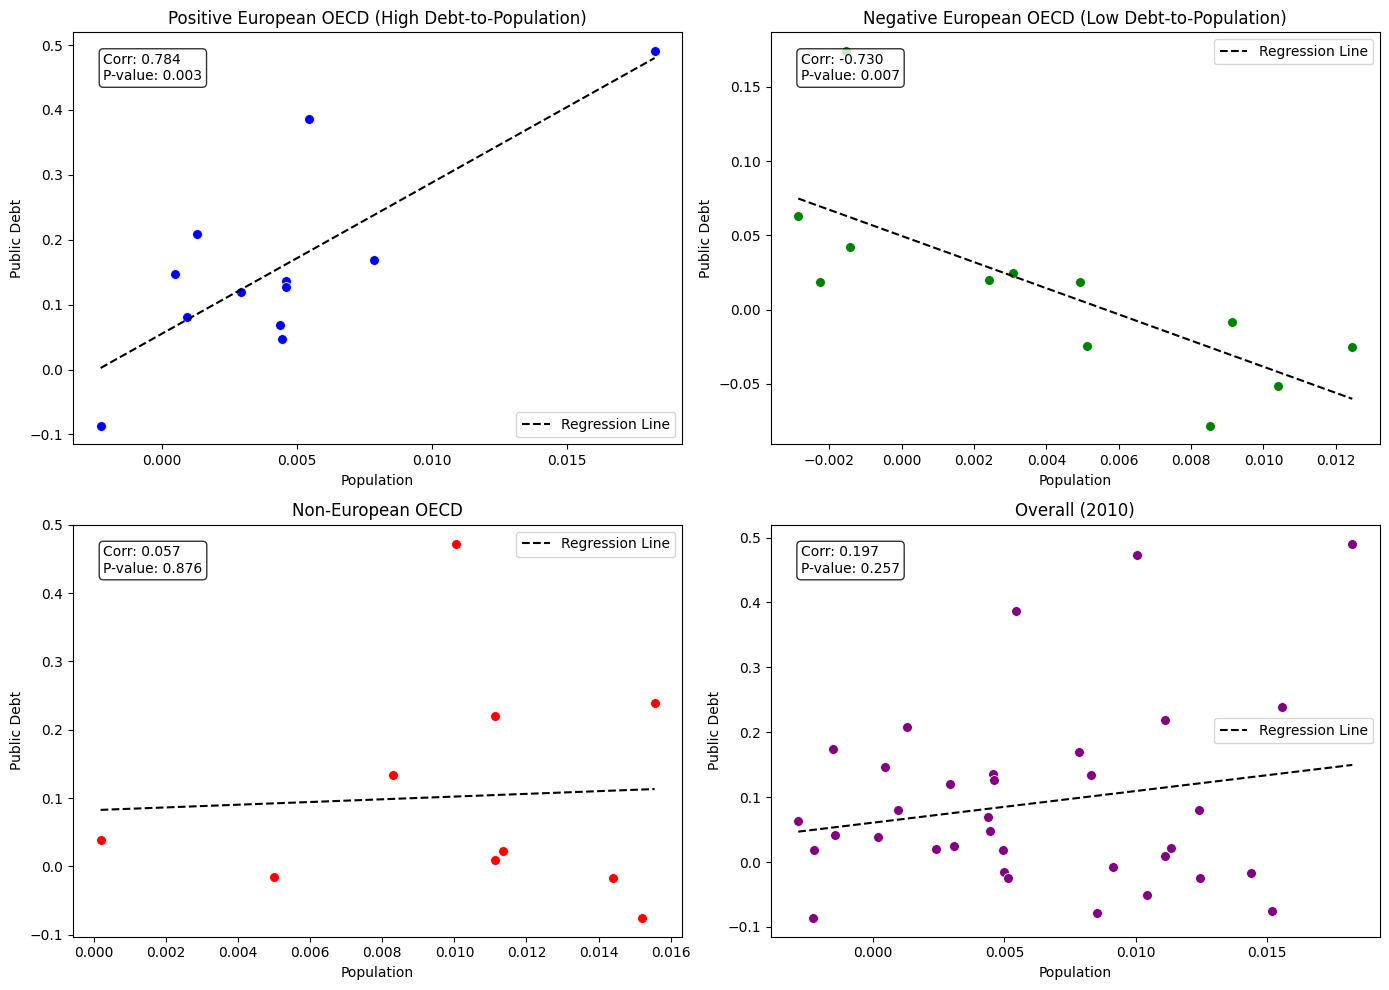

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Population')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Population')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Population', 'Public_Debt',
                'Positive European OECD (High Debt-to-Population)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Population', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Population)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Population', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Population', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
df_unemployment = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Unemployment_2010.csv')

In [23]:
df_unemployment.head()

,Country,Ccode,2010
0,Australia,AUS,-0.063073
1,Austria,AUT,-0.090858
2,Belgium,BEL,0.048685
3,Canada,CAN,-0.033333
4,Switzerland,CHE,0.170114


In [24]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_unemployment, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_unemployment = df_unemployment.melt(id_vars=["Country"], var_name="Year", value_name="Unemployment")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_unemployment, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Unemployment' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Unemployment'] = pd.to_numeric(df_long['Unemployment'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Unemployment"]).copy()

# IQR function with country tracking (only for Unemployment)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Unemployment and track removed countries
df_2010_clean, removed_countries_unemployment = drop_outliers_iqr(df_2010, "Unemployment")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_unemployment if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_unemployment if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-unemployment ratio (for 2010)
# Note: Unemployment can be zero or very small, so add a small constant to avoid division by zero
df_2010_european['Debt_to_Unemployment'] = df_2010_european["Public_Debt"] / (df_2010_european["Unemployment"] + 1e-6)
median_ratio = df_2010_european['Debt_to_Unemployment'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Unemployment'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Unemployment'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Unemployment"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Unemployment"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Unemployment): {model_pos.params['Unemployment']:.3f}, p-value: {model_pos.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Unemployment"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Unemployment) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Unemployment"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Unemployment): {model_neg.params['Unemployment']:.3f}, p-value: {model_neg.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Unemployment"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Unemployment: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Unemployment"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Unemployment): {model_non_eu.params['Unemployment']:.3f}, p-value: {model_non_eu.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Unemployment)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Unemployment"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Unemployment (2010) after removing outliers in Unemployment: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Unemployment"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Unemployment): {model_overall.params['Unemployment']:.3f}, p-value: {model_overall.pvalues['Unemployment']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Unemployment:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Unemployment:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Unemployment):", positive_european)
print("Negative European OECD countries (Low Debt-to-Unemployment):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Unemployment) after removing outliers: 0.387, p-value: 0.191 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Unemployment): 0.389, p-value: 0.191
R-squared: 0.150
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.942
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.191
Time:                        19:32:47   Log-Likelihood:                 12.786
No. Observations:                  13   AIC:                            -21.57
Df Residuals:                      11   BIC:                            -20.44
Df Model:                           1                                         
Covariance Type:        

<ipython-input-24-d75eefdc281f>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Unemployment'] = df_2010_european["Public_Debt"] / (df_2010_european["Unemployment"] + 1e-6)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: 

<ipython-input-26-7e8760ac17ad>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-26-7e8760ac17ad>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-26-7e8760ac17ad>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-26-7e8760ac17ad>

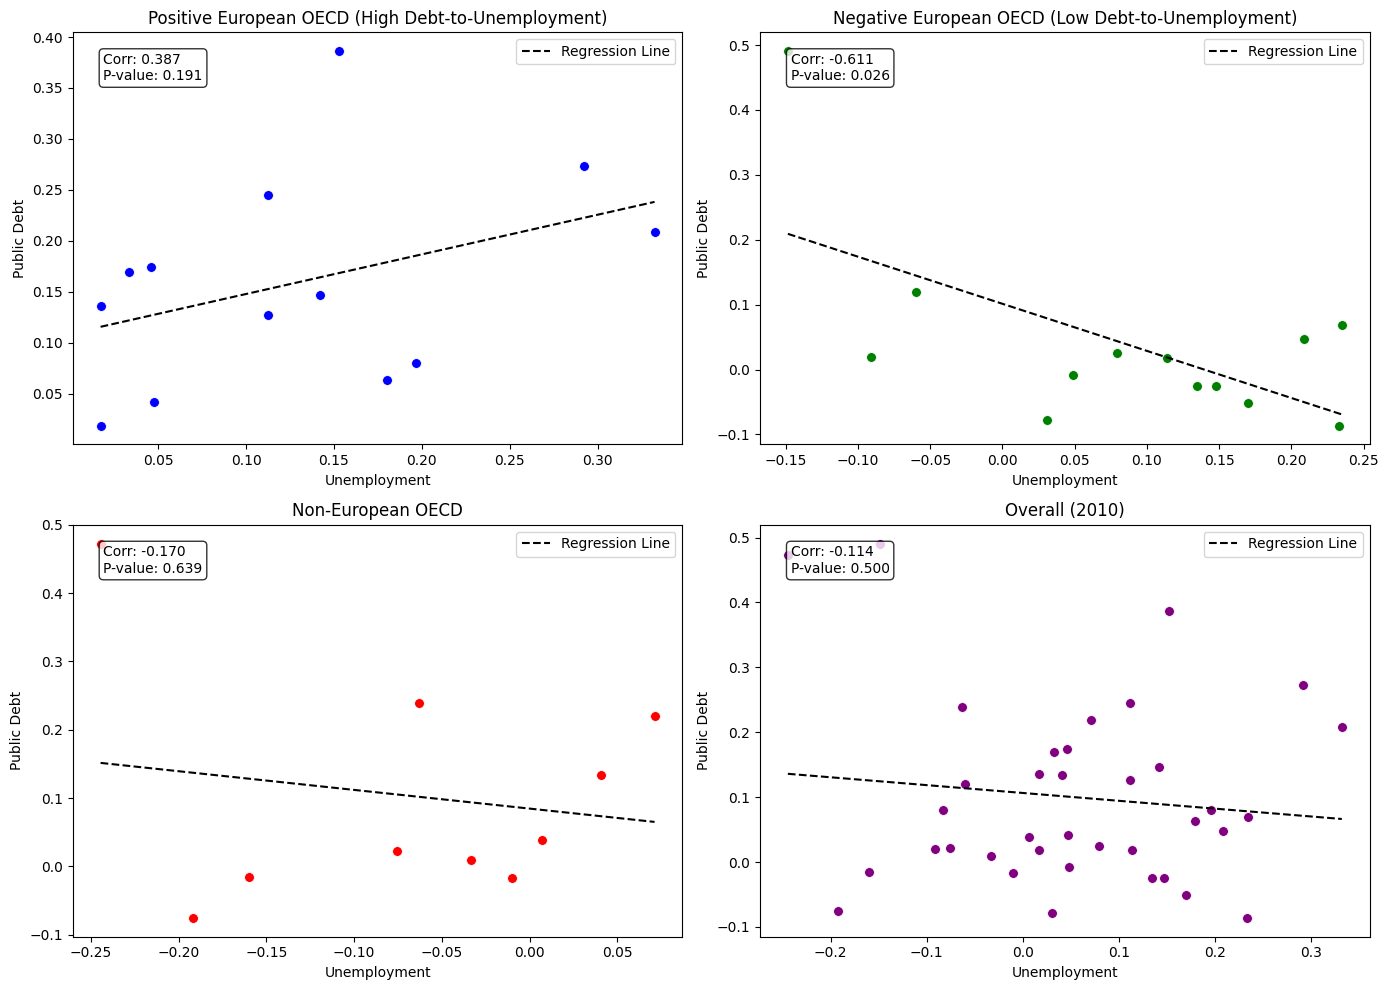

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Unemployment')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Unemployment')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Unemployment', 'Public_Debt',
                'Positive European OECD (High Debt-to-Unemployment)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Unemployment', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Unemployment)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Unemployment', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Unemployment', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
df_labor = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_Labor_Force_2010.csv')
df_labor.head()

,Country,CCode,2010
0,Australia,AUS,0.016519
1,Austria,AUT,0.003719
2,Belgium,BEL,0.019905
3,Canada,CAN,0.010566
4,Chile,CHL,0.021502


In [28]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_labor, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_labor = df_labor.melt(id_vars=["Country"], var_name="Year", value_name="Labor_Force")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_labor, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Labor_Force' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Labor_Force'] = pd.to_numeric(df_long['Labor_Force'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Labor_Force"]).copy()

# IQR function with country tracking (only for Labor_Force)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Labor_Force and track removed countries
df_2010_clean, removed_countries_labor = drop_outliers_iqr(df_2010, "Labor_Force")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_labor if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_labor if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-labor-force ratio (for 2010)
df_2010_european['Debt_to_Labor_Force'] = df_2010_european["Public_Debt"] / df_2010_european["Labor_Force"]
median_ratio = df_2010_european['Debt_to_Labor_Force'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Labor_Force'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Labor_Force'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Labor_Force"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Labor-Force) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Labor_Force"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Labor_Force): {model_pos.params['Labor_Force']:.3f}, p-value: {model_pos.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Labor_Force"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Labor-Force) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Labor_Force"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Labor_Force): {model_neg.params['Labor_Force']:.3f}, p-value: {model_neg.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Labor_Force"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Labor Force: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Labor_Force"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Labor_Force): {model_non_eu.params['Labor_Force']:.3f}, p-value: {model_non_eu.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Labor Force)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Labor_Force"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Labor Force (2010) after removing outliers in Labor Force: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Labor_Force"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Labor_Force): {model_overall.params['Labor_Force']:.3f}, p-value: {model_overall.pvalues['Labor_Force']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Labor Force:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Labor Force:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Labor-Force):", positive_european)
print("Negative European OECD countries (Low Debt-to-Labor-Force):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Labor-Force) after removing outliers: 0.652, p-value: 0.016 (Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Labor_Force): 15.609, p-value: 0.016
R-squared: 0.425
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     8.121
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0158
Time:                        19:35:20   Log-Likelihood:                 10.437
No. Observations:                  13   AIC:                            -16.87
Df Residuals:                      11   BIC:                            -15.74
Df Model:                           1                                         
Covariance Type:            n

<ipython-input-28-77790c16a448>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Labor_Force'] = df_2010_european["Public_Debt"] / df_2010_european["Labor_Force"]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning

<ipython-input-29-8d15800ec7e1>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-29-8d15800ec7e1>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-29-8d15800ec7e1>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-29-8d15800ec7e1>

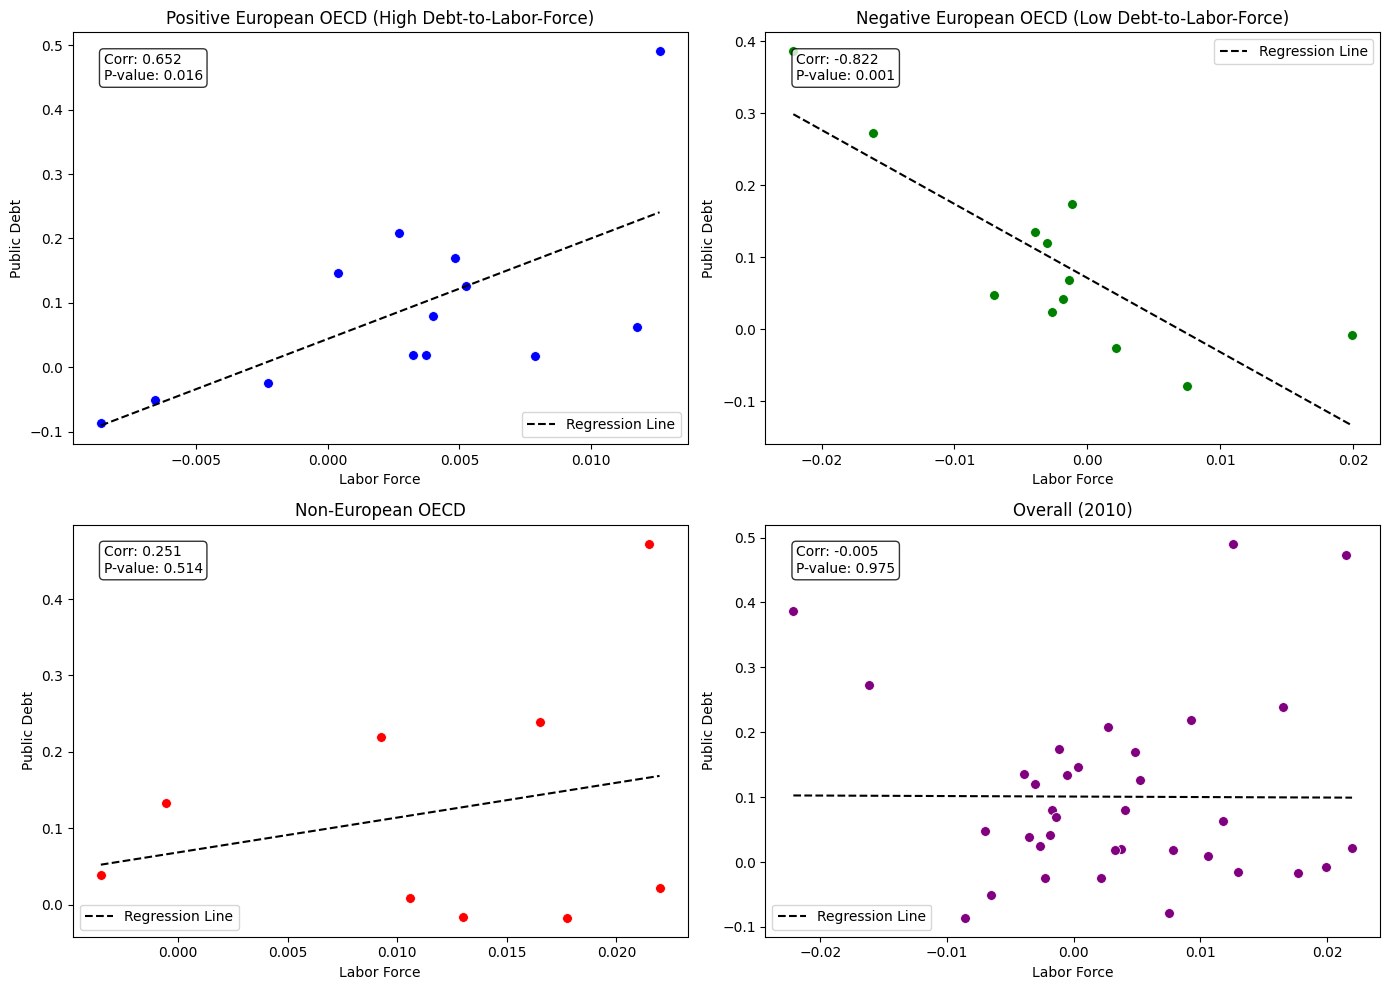

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Labor Force')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Labor Force')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Labor_Force', 'Public_Debt',
                'Positive European OECD (High Debt-to-Labor-Force)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Labor_Force', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Labor-Force)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Labor_Force', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Labor_Force', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
df_act = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/Cleaned_current_account_2010.csv')
df_act.head()

,Country,CCode,2010
0,Australia,AUS,-0.054559
1,Austria,AUT,0.113426
2,Belgium,BEL,-0.163993
3,Canada,CAN,0.426420
4,Switzerland,CHE,1.407375


In [31]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_act, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_act = df_act.melt(id_vars=["Country"], var_name="Year", value_name="Current_Account")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_act, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Current_Account' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Current_Account'] = pd.to_numeric(df_long['Current_Account'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Current_Account"]).copy()

# IQR function with country tracking (only for Current_Account)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Current_Account and track removed countries
df_2010_clean, removed_countries_act = drop_outliers_iqr(df_2010, "Current_Account")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_act if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_act if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-current-account ratio (for 2010)
# Note: Current Account can be negative or zero, so add a small constant to avoid division by zero
df_2010_european['Debt_to_Current_Account'] = df_2010_european["Public_Debt"] / (df_2010_european["Current_Account"] + 1e-6)
median_ratio = df_2010_european['Debt_to_Current_Account'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Current_Account'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Current_Account'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Current_Account"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Current-Account) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Current_Account"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Current_Account): {model_pos.params['Current_Account']:.3f}, p-value: {model_pos.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Current_Account"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Current-Account) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Current_Account"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Current_Account): {model_neg.params['Current_Account']:.3f}, p-value: {model_neg.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Current_Account"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Current Account: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Current_Account"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Current_Account): {model_non_eu.params['Current_Account']:.3f}, p-value: {model_non_eu.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Current Account)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Current_Account"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Current Account (2010) after removing outliers in Current Account: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Current_Account"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Current_Account): {model_overall.params['Current_Account']:.3f}, p-value: {model_overall.pvalues['Current_Account']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Current Account:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Current Account:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Current-Account):", positive_european)
print("Negative European OECD countries (Low Debt-to-Current-Account):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Current-Account) after removing outliers: 0.070, p-value: 0.829 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Current_Account): 0.019, p-value: 0.829
R-squared: 0.005
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.095
Method:                 Least Squares   F-statistic:                   0.04943
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.829
Time:                        19:37:25   Log-Likelihood:                 6.7941
No. Observations:                  12   AIC:                            -9.588
Df Residuals:                      10   BIC:                            -8.618
Df Model:                           1                                         
Covariance Type:  

<ipython-input-31-dd6e3910907d>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Current_Account'] = df_2010_european["Public_Debt"] / (df_2010_european["Current_Account"] + 1e-6)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py

<ipython-input-33-18ba5a5aab25>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-33-18ba5a5aab25>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-33-18ba5a5aab25>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-33-18ba5a5aab25>

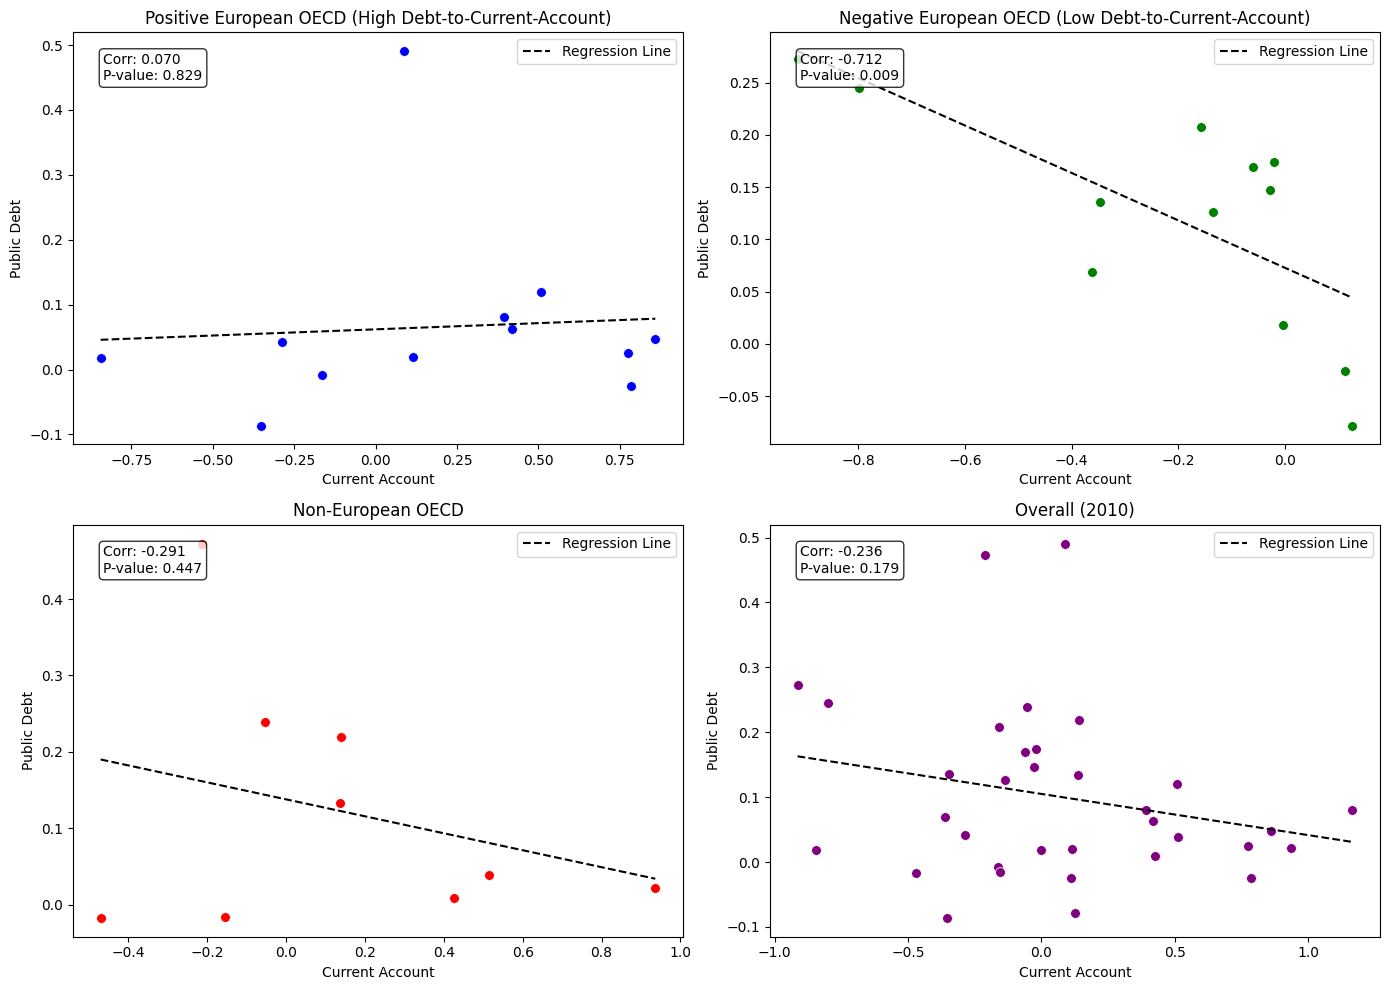

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Current Account')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Current Account')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Current_Account', 'Public_Debt',
                'Positive European OECD (High Debt-to-Current-Account)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Current_Account', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Current-Account)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Current_Account', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Current_Account', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()

In [34]:
df_inflation = pd.read_csv('/content/drive/MyDrive/Capstone Data/2010/clean_inflation_rate_2010.csv')
df_inflation.head()

,Country,Ccode,2010
0,Australia,AUS,0.029183
1,Austria,AUT,0.018135
2,Belgium,BEL,0.021893
3,Canada,CAN,0.017769
4,Switzerland,CHE,0.006882


In [35]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Merge Datasets based on 'Country'
merged_df = pd.merge(df_debt, df_inflation, on='Country', how='inner')

# Convert wide format (years as columns) to long format
df_long_debt = df_debt.melt(id_vars=["Country"], var_name="Year", value_name="Public_Debt")
df_long_inflation = df_inflation.melt(id_vars=["Country"], var_name="Year", value_name="Inflation")

# Merge the long format DataFrames
df_long = pd.merge(df_long_debt, df_long_inflation, on=['Country', 'Year'], how='inner')

# Convert 'Year' column to numeric, handling potential errors
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Convert 'Public_Debt' and 'Inflation' to numeric
df_long['Public_Debt'] = pd.to_numeric(df_long['Public_Debt'], errors='coerce')
df_long['Inflation'] = pd.to_numeric(df_long['Inflation'], errors='coerce')

# Filter to 2010
df_2010 = df_long[df_long["Year"] == 2010].dropna(subset=["Public_Debt", "Inflation"]).copy()

# IQR function with country tracking (only for Inflation)
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    removed_countries = df[(df[column] < lower) | (df[column] > upper)]["Country"].unique().tolist()  # Track unique removed countries
    df_cleaned = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_cleaned, removed_countries

# Drop outliers only for Inflation and track removed countries
df_2010_clean, removed_countries_inflation = drop_outliers_iqr(df_2010, "Inflation")

# Split removed countries into European and non-European OECD countries
removed_european_countries = [country for country in removed_countries_inflation if country in european_oecd_countries]
removed_non_european_countries = [country for country in removed_countries_inflation if country in non_european_oecd_countries]

# Filter out European and non-European OECD countries separately
df_2010_european = df_2010_clean[df_2010_clean["Country"].isin(european_oecd_countries)]
df_2010_non_european = df_2010_clean[df_2010_clean["Country"].isin(non_european_oecd_countries)]

# Split European countries into positive and negative groups based on debt-to-inflation ratio (for 2010)
# Note: Inflation can be negative (deflation) or zero, so add a small constant to avoid division by zero
df_2010_european['Debt_to_Inflation'] = df_2010_european["Public_Debt"] / (df_2010_european["Inflation"] + 1e-6)
median_ratio = df_2010_european['Debt_to_Inflation'].median()  # Use median of 2010 ratios
positive_european = df_2010_european[df_2010_european['Debt_to_Inflation'] >= median_ratio]["Country"].unique().tolist()
negative_european = df_2010_european[df_2010_european['Debt_to_Inflation'] < median_ratio]["Country"].unique().tolist()

# Filter European groups
df_positive_european = df_2010_european[df_2010_european["Country"].isin(positive_european)]
df_negative_european = df_2010_european[df_2010_european["Country"].isin(negative_european)]

# Compute correlation and regression for Positive European OECD countries
if len(df_positive_european) > 2:
    corr_positive, p_positive = pearsonr(df_positive_european["Public_Debt"], df_positive_european["Inflation"])
    sig_positive = "Significant" if p_positive < 0.05 else "Not Significant"
    print(f"2010 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: {corr_positive:.3f}, p-value: {p_positive:.3f} ({sig_positive})")

    X_pos = df_positive_european["Inflation"]
    y_pos = df_positive_european["Public_Debt"]
    X_pos = sm.add_constant(X_pos)
    model_pos = sm.OLS(y_pos, X_pos).fit()
    print("\nLinear Regression (Positive European OECD, 2010):")
    print(f"Coefficient (Inflation): {model_pos.params['Inflation']:.3f}, p-value: {model_pos.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_pos.rsquared:.3f}")
    print(model_pos.summary())
else:
    print(f"Not enough data for Positive European OECD countries. Sample size: {len(df_positive_european)}")

# Compute correlation and regression for Negative European OECD countries
if len(df_negative_european) > 2:
    corr_negative, p_negative = pearsonr(df_negative_european["Public_Debt"], df_negative_european["Inflation"])
    sig_negative = "Significant" if p_negative < 0.05 else "Not Significant"
    print(f"2010 Correlation for Negative European OECD countries (Low Debt-to-Inflation) after removing outliers: {corr_negative:.3f}, p-value: {p_negative:.3f} ({sig_negative})")

    X_neg = df_negative_european["Inflation"]
    y_neg = df_negative_european["Public_Debt"]
    X_neg = sm.add_constant(X_neg)
    model_neg = sm.OLS(y_neg, X_neg).fit()
    print("\nLinear Regression (Negative European OECD, 2010):")
    print(f"Coefficient (Inflation): {model_neg.params['Inflation']:.3f}, p-value: {model_neg.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_neg.rsquared:.3f}")
    print(model_neg.summary())
else:
    print(f"Not enough data for Negative European OECD countries. Sample size: {len(df_negative_european)}")

# Compute correlation and regression for non-European OECD countries
if len(df_2010_non_european) > 2:
    corr_non_european, p_non_european = pearsonr(df_2010_non_european["Public_Debt"], df_2010_non_european["Inflation"])
    sig_non_european = "Significant" if p_non_european < 0.05 else "Not Significant"
    print(f"2010 Correlation for non-European OECD countries after removing outliers in Inflation: {corr_non_european:.3f}, p-value: {p_non_european:.3f} ({sig_non_european})")

    X_non_eu = df_2010_non_european["Inflation"]
    y_non_eu = df_2010_non_european["Public_Debt"]
    X_non_eu = sm.add_constant(X_non_eu)
    model_non_eu = sm.OLS(y_non_eu, X_non_eu).fit()
    print("\nLinear Regression (Non-European OECD, 2010):")
    print(f"Coefficient (Inflation): {model_non_eu.params['Inflation']:.3f}, p-value: {model_non_eu.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_non_eu.rsquared:.3f}")
    print(model_non_eu.summary())
else:
    print("Not enough data left for non-European OECD countries after outlier removal.")

# Calculate the overall correlation and regression for 2010 (after removing outliers in Inflation)
if len(df_2010_clean) > 2:
    overall_corr, overall_p = pearsonr(df_2010_clean["Public_Debt"], df_2010_clean["Inflation"])
    sig_overall = "Significant" if overall_p < 0.05 else "Not Significant"
    print(f"Overall Correlation between Public Sector Debt and Inflation (2010) after removing outliers in Inflation: {overall_corr:.3f}, p-value: {overall_p:.3f} ({sig_overall})")

    X_overall = df_2010_clean["Inflation"]
    y_overall = df_2010_clean["Public_Debt"]
    X_overall = sm.add_constant(X_overall)
    model_overall = sm.OLS(y_overall, X_overall).fit()
    print("\nOverall Linear Regression (2010):")
    print(f"Coefficient (Inflation): {model_overall.params['Inflation']:.3f}, p-value: {model_overall.pvalues['Inflation']:.3f}")
    print(f"R-squared: {model_overall.rsquared:.3f}")
    print(model_overall.summary())
else:
    print("Not enough data left for overall correlation after outlier removal.")

# Print the countries that were removed and the European groups
print("\nEuropean OECD countries removed due to outliers in Inflation:", removed_european_countries if removed_european_countries else "None")
print("Non-European OECD countries removed due to outliers in Inflation:", removed_non_european_countries if removed_non_european_countries else "None")
print("Positive European OECD countries (High Debt-to-Inflation):", positive_european)
print("Negative European OECD countries (Low Debt-to-Inflation):", negative_european)

2010 Correlation for Positive European OECD countries (High Debt-to-Inflation) after removing outliers: 0.183, p-value: 0.613 (Not Significant)

Linear Regression (Positive European OECD, 2010):
Coefficient (Inflation): 3.944, p-value: 0.613
R-squared: 0.033
                            OLS Regression Results                            
Dep. Variable:            Public_Debt   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.087
Method:                 Least Squares   F-statistic:                    0.2771
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.613
Time:                        19:39:43   Log-Likelihood:                 7.0882
No. Observations:                  10   AIC:                            -10.18
Df Residuals:                       8   BIC:                            -9.571
Df Model:                           1                                         
Covariance Type:            no

<ipython-input-35-65034a814281>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_european['Debt_to_Inflation'] = df_2010_european["Public_Debt"] / (df_2010_european["Inflation"] + 1e-6)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWa

<ipython-input-36-872b6a2064a9>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-36-872b6a2064a9>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-36-872b6a2064a9>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range
<ipython-input-36-872b6a2064a9>

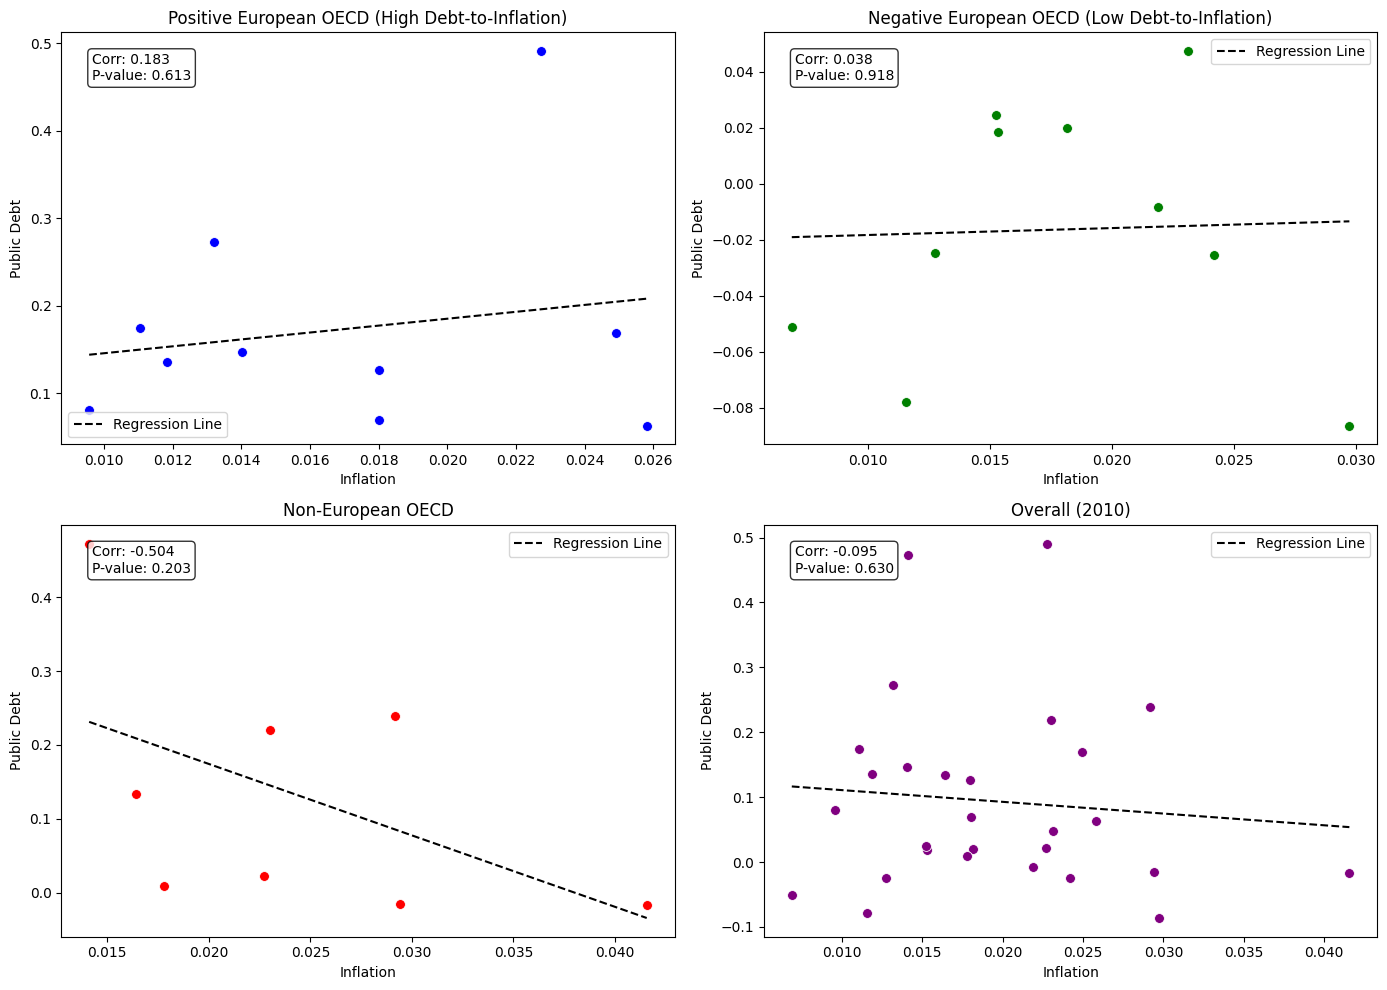

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Function to plot scatter with regression line
def plot_regression(df, x_col, y_col, title, ax, color):
    if len(df) > 2:
        # Scatter plot
        sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, color=color, s=50)

        # Regression line
        X = df[x_col]
        y = df[y_col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        x_range = np.linspace(X.min(), X.max(), 100)
        y_pred = model.params[0] + model.params[1] * x_range
        ax.plot(x_range, y_pred, color='black', linestyle='--', label='Regression Line')

        # Correlation and p-value
        corr, p_val = pearsonr(df[x_col], df[y_col])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}\nP-value: {p_val:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(title)
        ax.set_xlabel('Inflation')
        ax.set_ylabel('Public Debt')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Insufficient Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(title)
        ax.set_xlabel('Inflation')
        ax.set_ylabel('Public Debt')

# Plot for Positive European OECD
plot_regression(df_positive_european, 'Inflation', 'Public_Debt',
                'Positive European OECD (High Debt-to-Inflation)', axes[0], 'blue')

# Plot for Negative European OECD
plot_regression(df_negative_european, 'Inflation', 'Public_Debt',
                'Negative European OECD (Low Debt-to-Inflation)', axes[1], 'green')

# Plot for Non-European OECD
plot_regression(df_2010_non_european, 'Inflation', 'Public_Debt',
                'Non-European OECD', axes[2], 'red')

# Plot for Overall
plot_regression(df_2010_clean, 'Inflation', 'Public_Debt',
                'Overall (2010)', axes[3], 'purple')

# Adjust layout
plt.tight_layout()
plt.show()